# TUTORIAL
# Create synthetic truth and observations

This tutorial gives the details on how to use the function ```create_truth``` in ```essentials.create```.


All the code below can be summarized as 

```
truth = create_truth(TheModel, t_start=t_start, t_stop=t_stop, dt_obs=Nt_obs, t_max=t_max,
                     std_obs=noise_level, noise_type=noise_type, manual_bias=manual_bias, **true_parameters)
```


In [3]:
import parent_folders
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(6)


### 1. Create timeseries from the low-order model

Note that this data is clean and biased. Both the noise and the bias will be added in the next steps.

In [4]:
from essentials.physical_models import Lorenz63 as TheModel # available models: VdP, Lorenz63, Rijke, Annular

true_parameters = dict()
case = TheModel(**true_parameters)

t_max = case.t_transient * 5
psi, t = case.time_integrate(int(t_max / case.dt))
case.update_history(psi, t)

# Retrieve observables
y_true = case.get_observable_hist()
t_true = case.hist_t



### 2. (optional) Add bias 

If we do not add the bias, then the LOM is unbiased. Instead, if the true data is such that

$$
\mathbf{y}^\mathrm{true} =  \mathbf{y}^\mathrm{LOM} + \mathbf{b}^\mathrm{true}
$$

then the prediction from the LOM is biased.



In [5]:
name_bias = 'no bias'  # linear, periodic, time-varying, or no bias
def manual_bias(yy, tt):
    if name_bias[0] == 'l':
        return .1 * np.max(yy, axis=0) + .3 * yy
    elif name_bias[0] == 'p':
        return .2 * np.max(yy, axis=0) * np.cos(2 * yy / np.max(yy, axis=0))
    elif name_bias[0] == 't':
        return .4 * yy * np.sin((np.expand_dims(tt, -1) * np.pi * 2) ** 2)
    elif name_bias[0] == 'n':
        return np.zeros(1)
    else:
        raise ValueError('Bias type: ' + name_bias +' not recognzed.')

# The manual bias is a function of state and/or time
b_true = manual_bias(y_true, t_true)
    
# Add bias to the reference data
y_true += b_true

### 3. Add noise to the truth to create the observations

The noise type can be selected| between [Gaussian] noise, or coloured noise, from colours white, pink, brown, blue, and violet. Further, one can define the noise to be either [additive] or multiplicative. 

Note: 'gaussian, additive' is the pre-defined setting in ```create_noisy_observations```.

In [6]:
from essentials.Util import colour_noise

noise_level = 0.02
noise_type = 'pink' + 'additive' 

Nt, q = y_true.shape[:2]
y_raw = y_true.copy()

if 'gauss' in noise_type.lower():
    noise = rng.multivariate_normal(np.zeros(q), np.eye(q) * noise_level ** 2, Nt)
else:
    i0 = Nt % 2 != 0  # Add extra step if odd
    noise = np.zeros([Nt, q, 1])
    for ii in range(q):
        noise_white = np.fft.rfft(rng.standard_normal(Nt + i0) * noise_level)
        # Generate the noise signal
        S = colour_noise(Nt + i0, noise_colour=noise_type)
        S = noise_white * S / np.sqrt(np.mean(S ** 2))  # Normalize S
        noise[:, ii, 0] = np.fft.irfft(S)[i0:]  # transform back into time domain
if 'add' in noise_type.lower():
    y_raw += noise * np.max(abs(y_true))
else:
    y_raw += noise * y_raw


The function ```colour_noise```, which is included in *essentials.Util*, allows us to add different types of noises. We can visualize the different options.

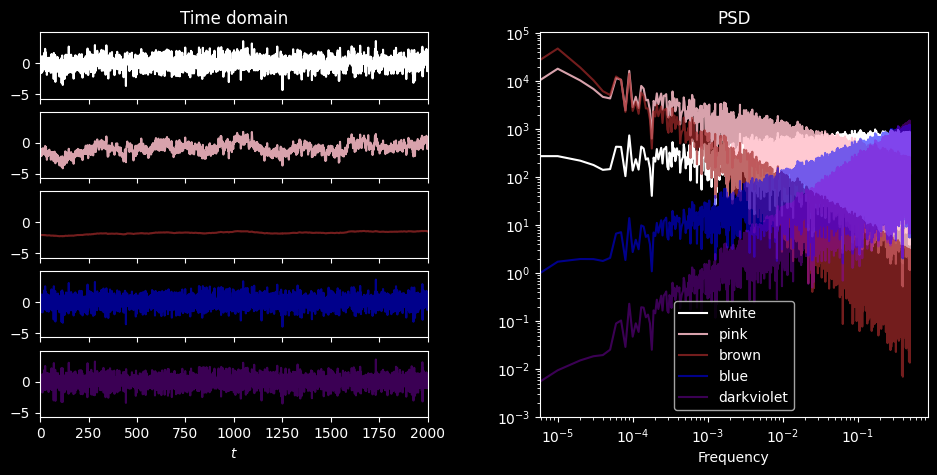

In [7]:
N = 100000

noise_white = np.fft.rfft(rng.standard_normal(N))
freq = np.fft.rfftfreq(N)

NOISES, PSDS = [], []
COLOURS = ['white', 'pink', 'brown', 'blue', 'darkviolet']
for noise_c in COLOURS:
    S = colour_noise(N, noise_colour=noise_c)
    S = noise_white * S / np.sqrt(np.mean(S ** 2))  # Normalize S
    noise = np.fft.irfft(S)  # transform back into time domain

    # Store
    PSDS.append(abs(S))
    NOISES.append(noise)
    
plt.style.use('dark_background')

fig = plt.figure(figsize=(10, 5))
figs = fig.subfigures(1, 2)
ax = figs[1].subplots(1, 1)
alpha = 1
for psd, c in zip(PSDS, COLOURS):
    ax.loglog(freq, psd, color=c, alpha=alpha)
    alpha -= 0.15
ax.legend(COLOURS)
ax.set(xlabel='Frequency', ylim=[1e-3, None], title='PSD')
    
axs = figs[0].subplots(len(COLOURS), 1, sharex='col', sharey='col')
alpha = 1
N_plot = 1000
for ax, noise, c in zip(axs, NOISES, COLOURS):
    ax.plot(np.arange(N), noise, color=c, alpha=alpha)
    alpha -= 0.15
axs[0].set(title='Time domain', xlim=[0, 2*N_plot])
axs[-1].set(xlabel='$t$');


We can observe that
* White noise has an almost-flat PSD in the frequency domain, i.e., all the frequencies are equally present
* Brownian and pink noises strength is lowest at higher frequencies, which is visualized in the time domain with seamingly non-zero mean.
* Blue and violet noise strenght increases with the frequency.

## 4. Define observations

We define the assimilation window and the time between obsevations


In [8]:

t_start = case.t_transient
t_stop = t_start + 10 * case.t_CR

dt_t = t_true[1] - t_true[0]
Nt_obs = 20 
dt_obs = dt_t * Nt_obs


obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)
t_obs, y_obs = t_true[obs_idx], y_raw[obs_idx]


### 5. Finally, save the data in a dictionary

In [9]:
name_truth = '{}_{}_{}'.format(case.name, name_bias, noise_type)
for key in case.params:
    name_truth += key + '{:.2e}'.format(getattr(case, key)) + '_'

truth = dict(y_raw=y_raw, y_true=y_true, t=t_true, b=b_true, dt=dt_t,
             t_obs=t_obs, y_obs=y_obs, dt_obs=dt_obs,
             name=name_truth, name_bias=name_bias, noise_type=noise_type,
             model=type(case), std_obs=noise_level, true_params=true_parameters)

With the function ```plot_truth``` in ```essentials.Util``` we can visualize the created true data.

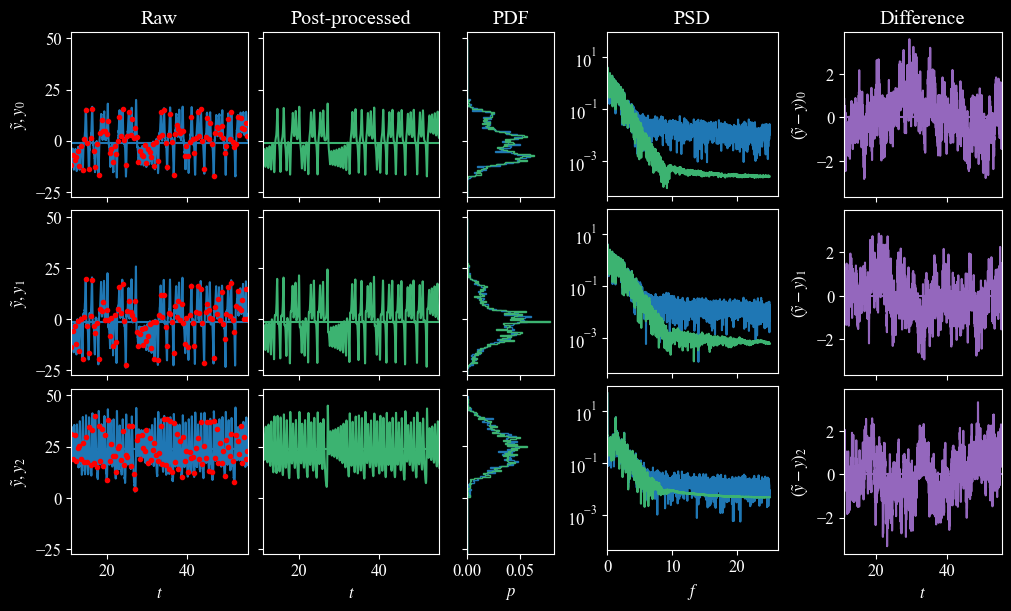

In [10]:
from essentials.plotResults import plot_truth

plot_truth(**truth)